## Doc du lieu

In [284]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib.dates import date2num
import plotly.graph_objs as go
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [285]:
df = pd.read_csv("./data_thuchanh.csv", encoding="latin-1", sep=';')

In [286]:
feats= ['4']

## Xay dung mo hinh gau

In [287]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]).reshape(-1,1))


In [288]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [289]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [290]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.1,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000281905
[200]	valid_0's multi_logloss: 0.000291984
[200]	valid_0's multi_logloss: 0.000267879
[200]	valid_0's multi_logloss: 0.000165331
[400]	valid_0's multi_logloss: 0.000165034
[600]	valid_0's multi_logloss: 0.000164946
[800]	valid_0's multi_logloss: 0.000164905
[1000]	valid_0's multi_logloss: 0.000164881
[1200]	valid_0's multi_logloss: 0.000164866
[1400]	valid_0's multi_logloss: 0.000164855
[1600]	valid_0's multi_logloss: 0.000164847
[1800]	valid_0's multi_logloss: 0.000164841
[2000]	valid_0's multi_logloss: 0.000164836
[2200]	valid_0's multi_logloss: 0.000164832
[2400]	valid_0's multi_logloss: 0.000164828
[2600]	valid_0's multi_logloss: 0.000164826
[2800]	valid_0's multi_logloss: 0.000164823
[3000]	valid_0's multi_logloss: 0.000164821
[3200]	valid_0's multi_logloss: 0.00016482
[3400]	valid_0's multi_logloss: 0.000164818
[3600]	valid_0's multi_logloss: 0.000164817
[3800]	valid_0's multi_logloss: 0.000164815
[4000]	valid_0's multi_logloss: 0.000164

In [291]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [292]:
labels=np.argmax(lgb_preds,axis=1)

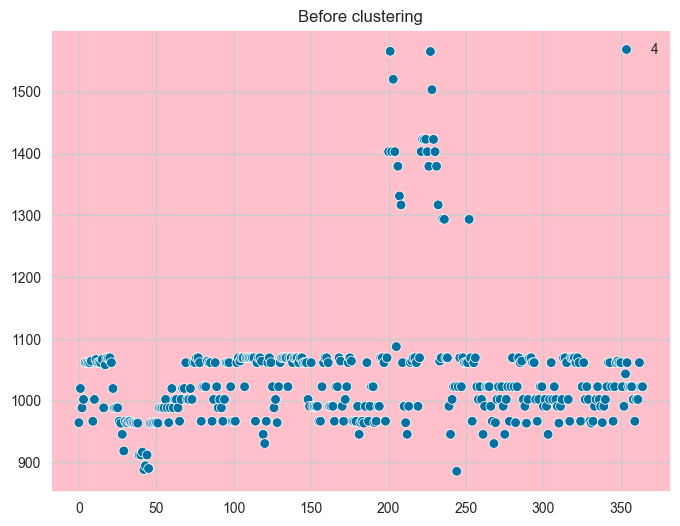

In [293]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o');
ax.set_title("Before clustering");

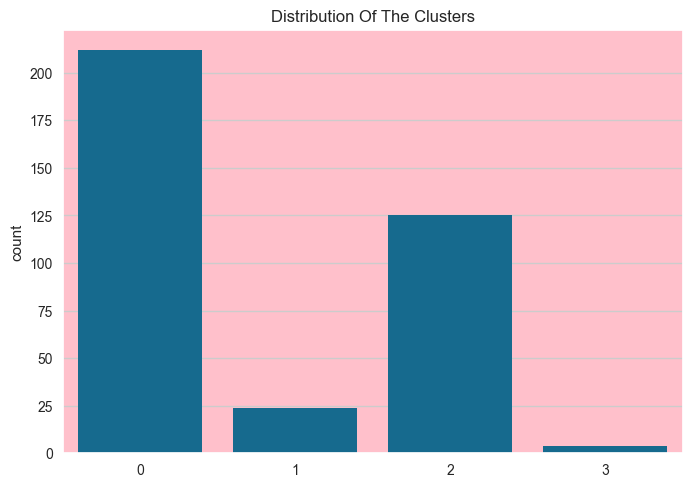

In [294]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

## Xay dung mo hinh LSTM

In [295]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [296]:
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [297]:
test_size = df[df['Ngày'].dt.month==12].shape[0]
test_size

31

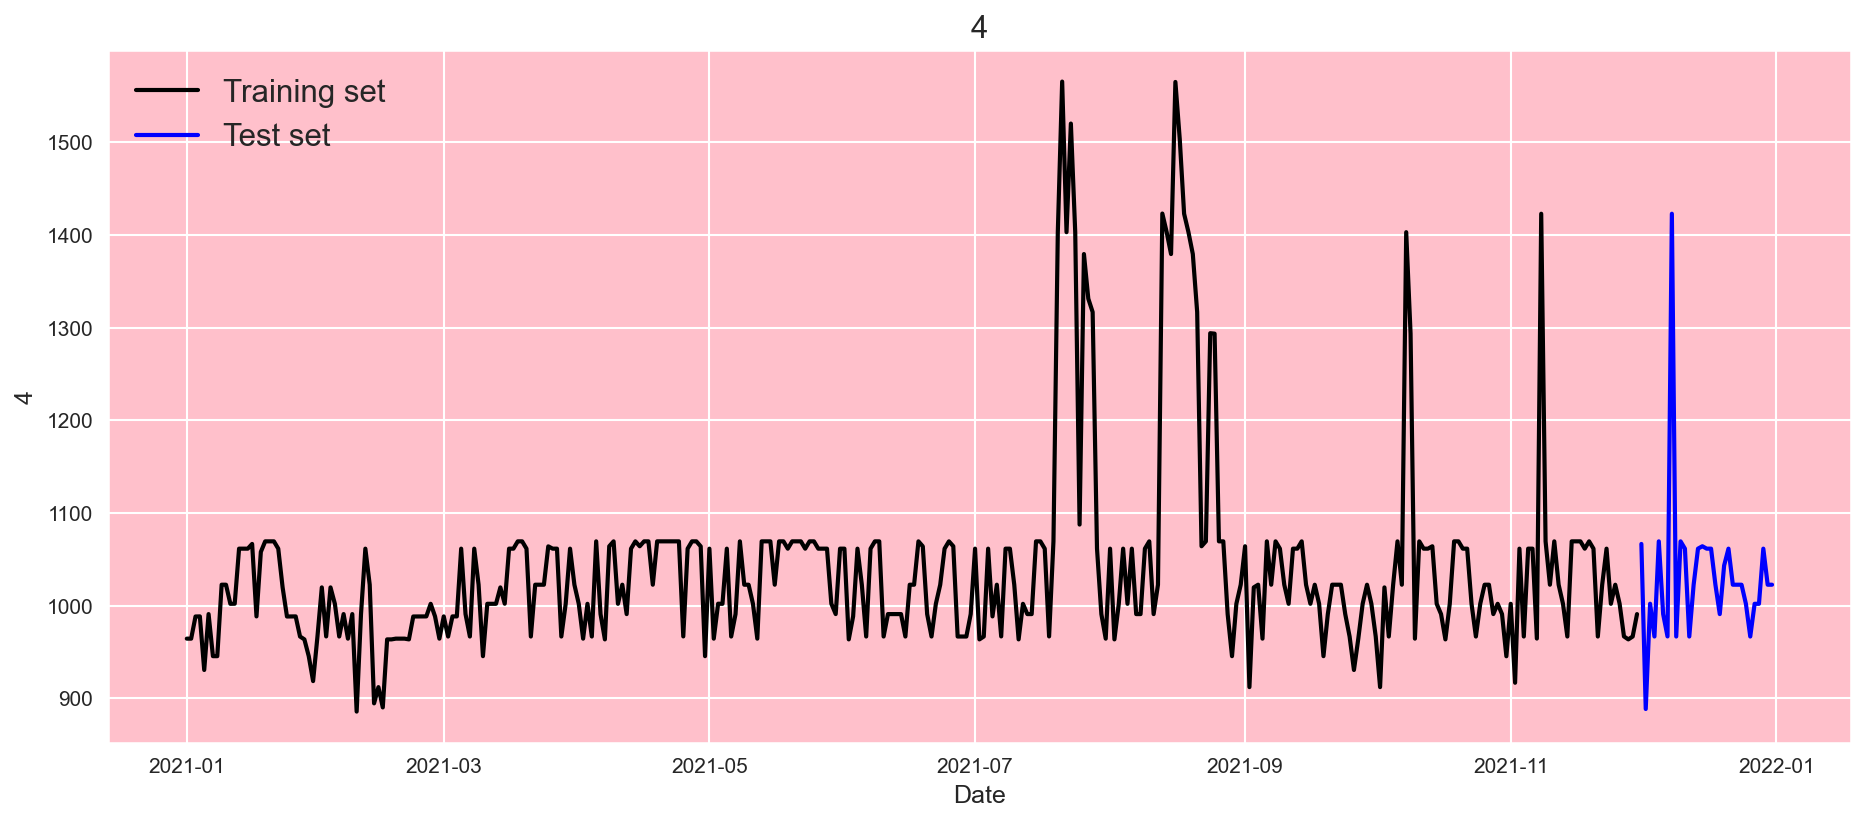

In [298]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'pink'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['4'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['4'][-test_size:], color='blue', lw=2)
plt.title('4', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [299]:
import plotly.express as px
fig = px.line(y=df['4'], x=df['Ngày'])
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Ngày",
                  yaxis_title="4",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='pink')

In [300]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['4'].values.reshape(-1,1))

MinMaxScaler()

In [301]:
window_size = 30

In [302]:
train_data = df['4'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [303]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [304]:
test_data = df['4'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [305]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [306]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [307]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [308]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [309]:
model = define_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 3s 36ms/step - loss: 0.0817 - val_loss: 0.0166
Epoch 2/100
18/18 [==============================] - 0s

In [310]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 439ms/step


In [311]:
from sklearn.metrics import mean_absolute_percentage_error,accuracy_score,r2_score
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1-MAPE

In [312]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.019344938918948174
Test MAPE: 1.896938503226596
Test Accuracy: -0.896938503226596


In [313]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

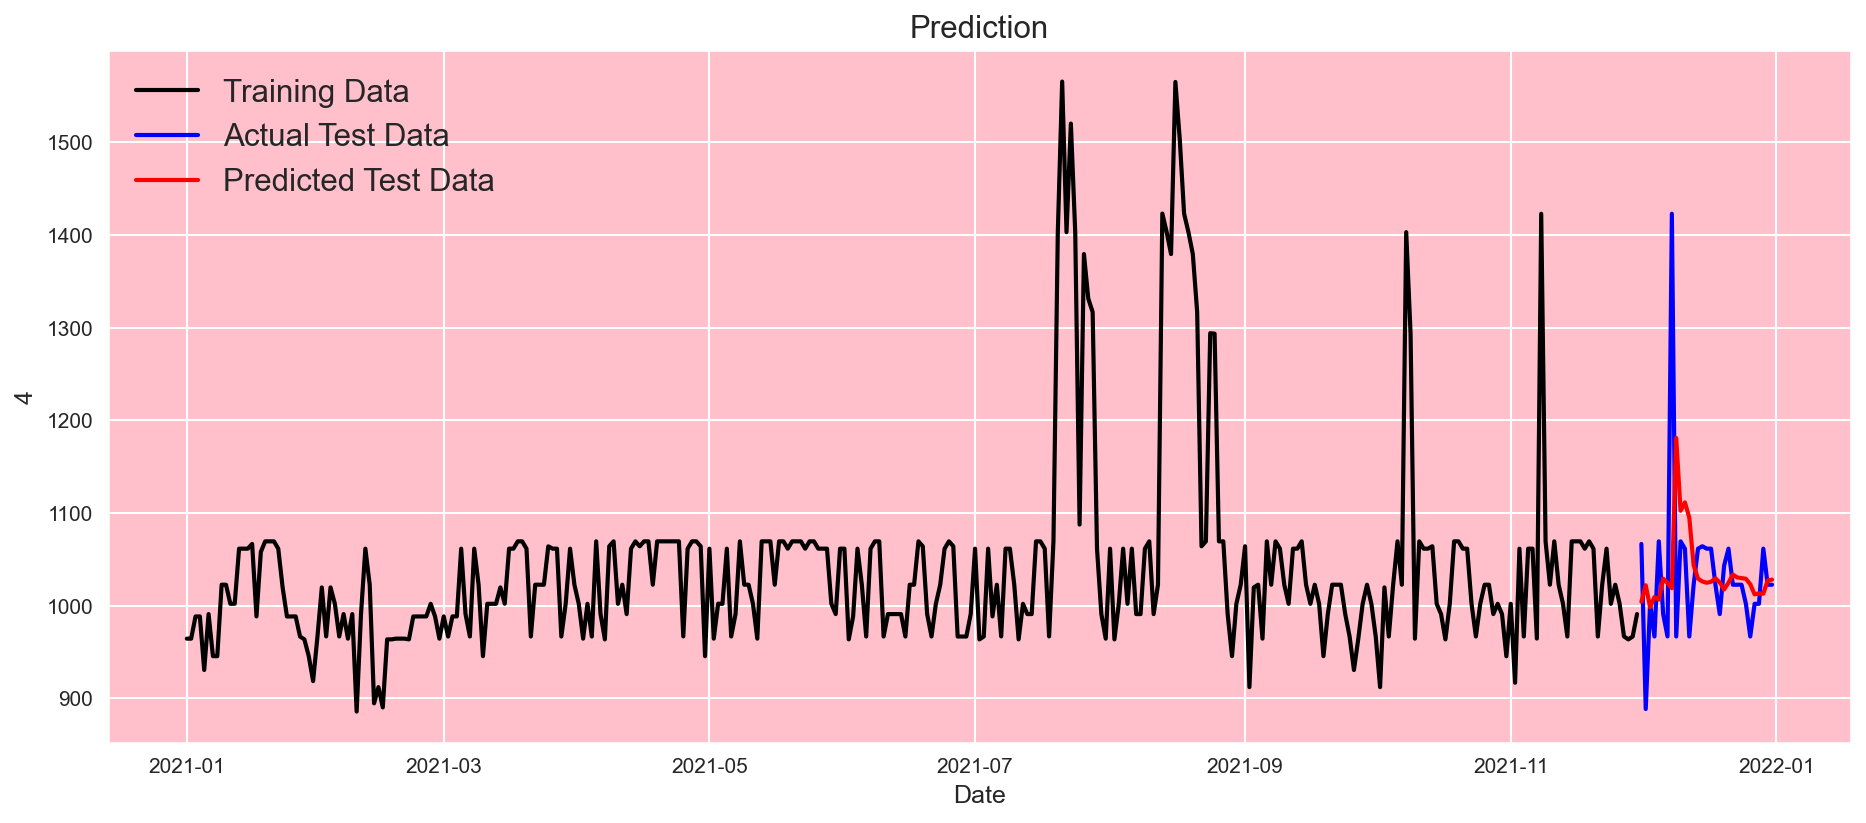

In [314]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'pink'
plt.rc('axes',edgecolor='white')
plt.plot(df['Ngày'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngày'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('4', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## Xay dung mo hinh Sarima

In [315]:
data_srm = df[feats]

In [316]:
# Kiểm tra tính dừng của chuỗi thời gian
adf_test = adfuller(data_srm)
print(f'p-value: {adf_test[1]}')
if(adf_test[1] > 0.05):
    print("Chuỗi chưa dừng, cần phải xử lý")
else:
    print("Chuỗi đã dừng, có thể sử dụng vào model")

p-value: 0.00010932055953615445
Chuỗi đã dừng, có thể sử dụng vào model


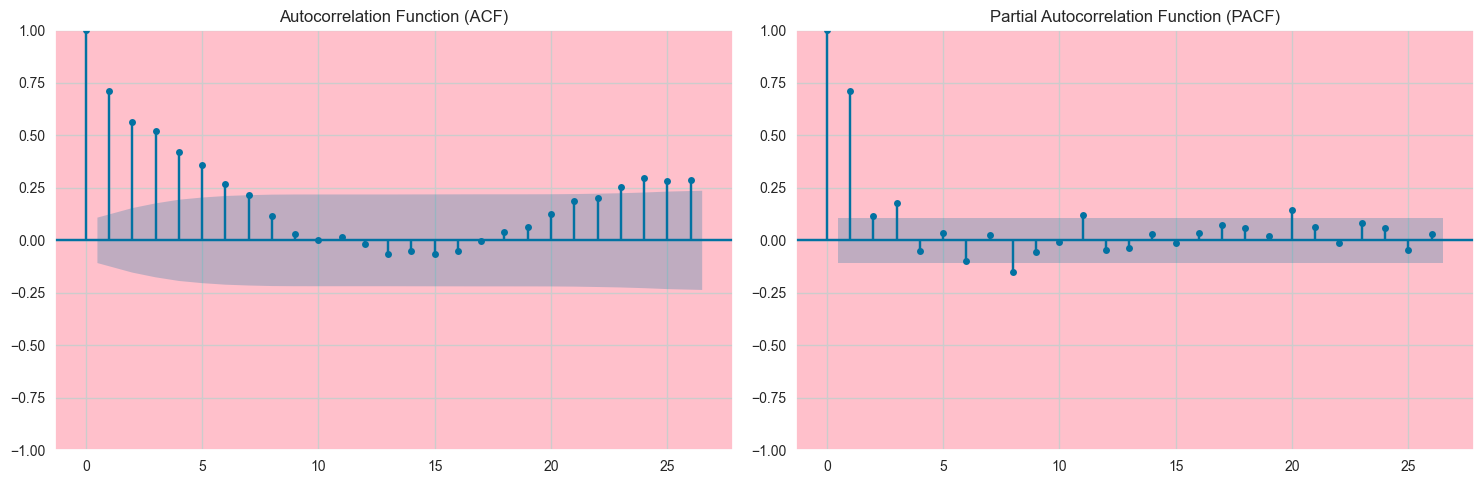

In [317]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_train_goc, ax=ax1)
plot_pacf(df_train_goc, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF)')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [318]:
train_size = int(len(data_srm) * 0.9)
df_train, df_test = data_srm[:train_size], data_srm[train_size:]

In [326]:
p, d, q = 3, 0, 1
P, D, Q, s = 3, 0, 1, 30

In [327]:
model_sarima = SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()

In [321]:
forecast_diff = model_fit_sarima.forecast(steps=len(df_test))
print(forecast_diff)

328     998.085858
329     950.742045
330     961.778368
331     968.375809
332     962.620394
333     960.852329
334     967.410280
335     958.843832
336     966.506996
337     976.900969
338    1000.929808
339     981.891761
340    1013.225086
341    1042.078888
342     991.934165
343     984.766590
344    1036.661041
345    1030.218999
346    1036.746924
347    1041.829119
348    1042.269608
349    1035.300003
350    1063.858510
351    1073.776352
352    1059.123036
353    1051.704063
354    1026.885535
355    1026.920785
356    1041.751750
357    1005.417573
358     998.014829
359     950.671016
360     961.707339
361     968.304780
362     962.549365
363     960.781300
364     967.339252
Name: predicted_mean, dtype: float64


In [322]:
df_pre_goc = forecast_diff.cumsum() + df_train_goc.iloc[-1]
print(df_pre_goc)

328   NaN
329   NaN
330   NaN
331   NaN
332   NaN
333   NaN
334   NaN
335   NaN
336   NaN
337   NaN
338   NaN
339   NaN
340   NaN
341   NaN
342   NaN
343   NaN
344   NaN
345   NaN
346   NaN
347   NaN
348   NaN
349   NaN
350   NaN
351   NaN
352   NaN
353   NaN
354   NaN
355   NaN
356   NaN
357   NaN
358   NaN
359   NaN
360   NaN
361   NaN
362   NaN
363   NaN
364   NaN
4     NaN
dtype: float64


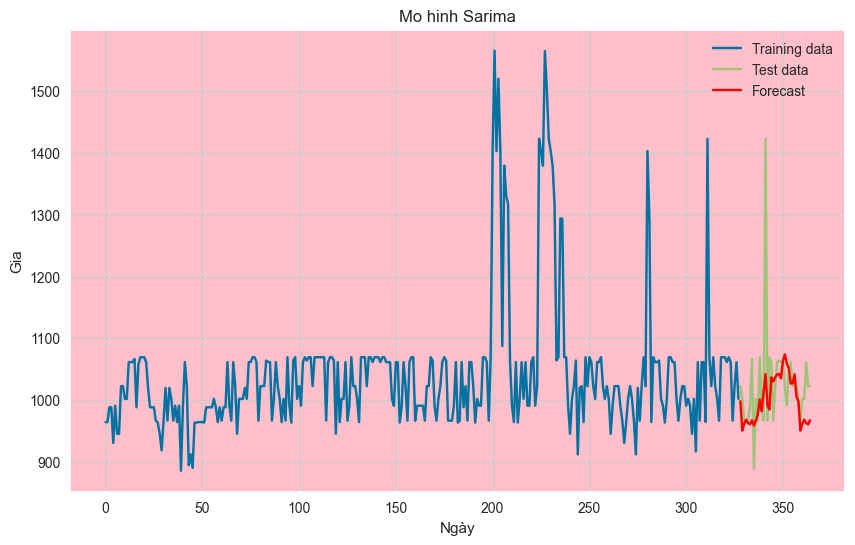

In [323]:
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train, label='Training data')
plt.plot(df_test.index, df_test, label='Test data')
plt.plot(df_test.index, forecast_diff, color='red', label='Forecast')
plt.title('Mo hinh Sarima')
plt.xlabel('Ngày')
plt.ylabel('Gia')
plt.legend()
plt.show()